<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/vitaldb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VitalDB 데이터 셋 이용
오픈 생체 신호 데이터셋인 VitalDB를 이용하는 모든 사용자는 반드시 아래 Data Use Agreement에 동의하여야 합니다.

https://vitaldb.net/data-bank/?query=guide&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.usmoena3l4rb

동의하지 않을 경우 이 창을 닫으세요. 

## 필요한 헤더

In [1]:
import pandas as pd
import numpy as np

## 임상 정보 받아오기

In [2]:
df_cases = pd.read_csv("https://api.vitaldb.net/cases")
df_cases

,caseid,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,devices,tracks,casedur,filesize,age,sex,height,weight,bmi,asa,emop,department,optype,dx,opname,approach,position,ane_type,opdur,anedur,los_postop,los_icu,death_inhosp,preop_htn,preop_dm,preop_arrhythmia,preop_pft,preop_hb,preop_plt,preop_pt,preop_aptt,preop_na,preop_k,preop_glucose,preop_alb,preop_got,preop_gpt,preop_bun,preop_cr,preop_ph,preop_hco3,preop_be,preop_pao2,preop_paco2,preop_spo2,cormack,airway,tubesize,dltubesize,lmasize,iv1,iv2,aline1,aline2,cline1,cline2,intraop_ebl,intraop_uo,intraop_rbc,intraop_ffp,intraop_crystalloid,intraop_colloid,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca
0,1,0,11520,-540,10860,-540,10380,-236220,627780,4,78,192,21.3,77.0,M,160.2,67.50,26.3,2.0,N,General surgery,Colorectal,Rectal cancer,Low anterior resection,Open,Lithotomy,General,145,180,8,0,N,Y,N,N,Normal,14.1,189,94.0,33.2,141.0,3.1,134.0,4.3,18,16,10.0,0.82,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Right forearm,N,Left radial,N,N,N,NaN,300.0,0,0,350.0,0,120,0.0,100,70,0,10,0,0,0
1,2,0,15720,-1020,14940,1740,14640,-221160,1506840,5,75,262,26.3,54.0,M,167.3,54.80,19.6,2.0,N,General surgery,Stomach,Advanced gastric cancer,Subtotal gastrectomy,Open,Supine,General,215,245,19,0,N,N,N,N,Normal,10.2,251,110.0,31.9,143.0,4.7,88.0,3.8,18,15,14.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,N,N,N,N,N,50.0,700.0,0,0,800.0,0,150,0.0,0,100,0,20,0,0,0
2,3,0,4440,-540,4260,-540,3960,-218640,40560,5,80,73,6.6,62.0,M,169.1,69.70,24.4,1.0,N,General surgery,Biliary/Pancreas,Gallbladder stone,Cholecystectomy,Videoscopic,Reverse Trendelenburg,General,32,65,2,0,N,N,N,N,Normal,14.2,373,103.0,30.3,144.0,4.9,87.0,4.2,17,34,14.0,1.18,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,N,N,N,N,N,NaN,NaN,0,0,200.0,0,0,0.0,0,50,0,0,0,0,0
3,4,0,21000,-720,20280,2580,18180,-201120,576480,5,74,350,28.3,74.0,M,160.6,53.00,20.5,2.0,N,General surgery,Stomach,Advanced gastric cancer,Distal gastrectomy,Videoscopic,Reverse Trendelenburg,General,255,335,7,1,N,Y,N,N,Normal,14.4,275,103.0,34.5,141.0,4.2,108.0,4.1,23,18,10.0,0.96,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,NaN,NaN,NaN,Left forearm,N,Right radial,N,N,N,NaN,270.0,0,0,2700.0,0,80,0.0,100,100,0,50,0,0,0
4,5,0,21540,-960,22440,2640,21840,-67560,3734040,6,99,359,41.0,66.0,M,171.0,59.70,20.4,3.0,Y,General surgery,Vascular,Aortic aneurysm,Aneurysmal repair,Open,Prone,General,295,350,45,13,N,Y,N,Left anterior fascicular block,Normal,10.1,67,73.0,36.5,146.0,4.4,126.0,2.6,765,77,50.0,4.43,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Right forearm,N,Right radial,N,Right IJV,N,2600.0,1490.0,8,8,7100.0,0,0,0.0,0,160,0,10,900,0,2100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6383,6384,0,15240,-240,15660,-240,15060,-215340,648660,5,73,254,9.3,64.0,M,161.5,63.00,24.2,1.0,N,General surgery,Stomach,Advanced gastric cancer,Total gastrectomy,Open,Supine,General,200,245,8,0,N,N,N,N,Normal,14.5,279,109.0,31,NaN,NaN,100.0,4.2,31,33,13.0,0.99,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,N,N,N,N,N,100.0,330.0,0,0,550.0,0,150,0.0,0,90,0,20,0,0,0
6384,6385,0,20640,-540,21000,-540,19800,-225600,1675200,5,76,344,29.0,69.0,M,159.3,62.30,24.6,2.0,N,General surgery,Colorectal,"Colon submucosal tumor, unknown behavior",Ultralow anterior resection,Videoscopic,Lithotomy,General,285,335,20,0,N,Y,N,N,Normal,15.2,239,114.0,28.7,144.0,4.0,140.0,3.7,18,28,19.0,0.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.5,NaN,NaN,Right forearm,Left forearm,Right radial,N,N,N,100.0,250.0,0,0,2500.0,0,100,0.0,0,100,0,25,30,0,300
6385,6386,0,19440,-660,19140,3540,18540,-200460,836340,5,76,324,31.4,61.0,F,151.7,43.25,18.8,1.0,N,General surgery,Stomach,Earl

## 트랙 정보 받아오기

In [3]:
df_trks = pd.read_csv("https://api.vitaldb.net/v2/trks")
df_trks

,caseid,tname,tid
0,1,BIS/BIS,fd869e25ba82a66cc95b38ed47110bf4f14bb368
1,1,BIS/EEG1_WAV,0aa685df768489a18a5e9f53af0d83bf60890c73
2,1,BIS/EEG2_WAV,ad13b2c39b19193c8ae4a2de4f8315f18d61a57e
3,1,BIS/EMG,2525603efe18d982764dbca457affe7a45e766a9
4,1,BIS/SEF,1c91aec859304840dec75acf4a35da78be0e8ef0
...,...,...,...
537092,6388,Solar8000/VENT_PIP,2d63adbc7e2653f14348e219816673cde3358cf6
537093,6388,Solar8000/VENT_PPLAT,6f6604255858ddc8f6a01b9f4774b0d43105f6da
537094,6388,Solar8000/VENT_RR,f34f3fae7fd963355c1c7060e1e876d20fa87536
537095,6388,Solar8000/VENT_SET_TV,4a4a55b8aebf9c76a4a76f62a7c1ec6fcb80e618


In [4]:
caseids = list(
    set(df_trks[df_trks['tname'] == 'Solar8000/ART_MBP']['caseid']) & 
    set(df_cases[df_cases['age'] > 18]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("transplant")]['caseid'])
)
print(len(caseids))

3452


## 트랙 ID (tid) 구하기
* caseid 와 트랙명으로부터 구한다.
* 트랙명의 리스트는 https://vitaldb.net/data-bank/?query=param

In [5]:
caseid = 6388
tid = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/ART_MBP')]['tid'].values[0]
tid

'8132234ea9f472b48d012f50892cd495de3871c9'

## 검사 결과 데이터 로딩

In [6]:
labs = pd.read_csv('https://api.vitaldb.net/labs')
labs

,caseid,dt,name,result
0,1867,143869,Calcium,8.70
1,1867,143869,Phosphorus,3.20
2,1867,143869,BUN,10.00
3,1867,143869,Uric Acid,7.10
4,1867,143869,"Protein, total",7.30
...,...,...,...,...
1276506,3549,12900803,Creatinine,4.77
1276507,3549,12900803,Sodium,134.00
1276508,3549,12900803,Potassium,3.50
1276509,3549,12900803,Chloride,111.00


## Wave 트랙 데이터 로딩

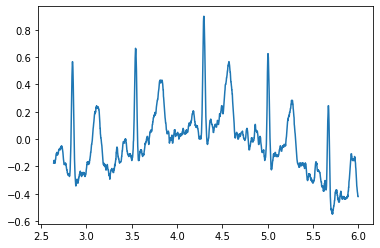

In [7]:
ecg_wav = pd.read_csv('https://api.vitaldb.net/395df4819e4e1f0d123d14f042667975f5945504').interpolate(columns=[0]).values

import matplotlib.pyplot as plt
plt.plot(ecg_wav[:3000,0], ecg_wav[:3000,1])  # 500hz

## Numeric 트랙 데이터 로딩

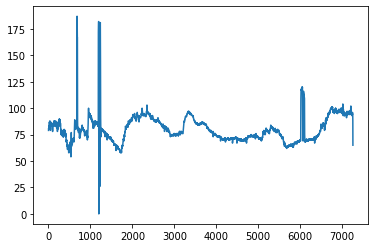

In [8]:
mbps = pd.read_csv('https://api.vitaldb.net/72a06ceb9ab1a067f3cc4be203dbeaebe69831d5').values

import matplotlib.pyplot as plt
plt.plot(mbps[:,0], mbps[:,1])

## Numeric 트랙을 일정 시간 간격으로 로딩

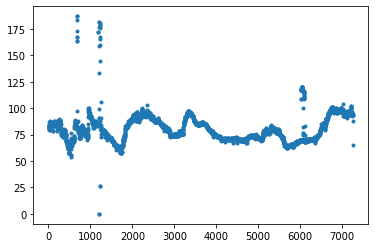

In [9]:
def load_trk(tid, interval=1):
    try:
        url = 'https://api.vitaldb.net/' + tid
        dtmbps = pd.read_csv(url).values
    except:
        return np.empty(0)
    if len(dtmbps) == 0:
        return np.empty(0)
    dtmbps[:,0] /= interval  # convert time to row
    trklen = int(np.nanmax(dtmbps[:,0])) + 1  # find maximum index (array length)
    ret = np.full(trklen, np.nan)  # create a dense array
    for idx, val in dtmbps:  # copy values
        ret[int(idx)] = val
    return ret

mbps = load_trk('72a06ceb9ab1a067f3cc4be203dbeaebe69831d5')

import matplotlib.pyplot as plt
plt.plot(np.arange(len(mbps)), mbps, '.')

## 여러 트랙을 한번에 로딩

In [10]:
def load_trks(tids, interval=1):
    trks = []
    maxlen = 0
    for tid in tids:
        trk = load_trk(tid, interval)
        trks.append(trk)
        if len(trk) > maxlen:
            maxlen = len(trk)
    if maxlen == 0:
        return np.empty(0)
    ret = np.full((maxlen, len(tids)), np.nan)  # create a dense array
    for i in range(len(tids)):  # copy values
        ret[:len(trks[i]), i] = trks[i]
    return ret

# 현 case의 트랙을 로딩
caseid = 1
sbp_tid = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/NIBP_SBP')]['tid'].values[0]
mbp_tid = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/NIBP_MBP')]['tid'].values[0]
dbp_tid = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/NIBP_DBP')]['tid'].values[0]
vals = load_trks([sbp_tid, mbp_tid, dbp_tid], 60)
vals

array([[ nan,  nan,  nan],
       [150., 100.,  84.],
       [177., 109.,  75.],
       [178.,  96.,  74.],
       [172., 102.,  77.],
       [172., 102.,  77.],
       [172., 134.,  85.],
       [125.,  74.,  60.],
       [107.,  76.,  65.],
       [107.,  76.,  65.],
       [107., 153.,  65.],
       [199., 145., 100.],
       [199., 145., 100.],
       [199., 145., 100.]])

In [11]:
print(sbp_tid)
print(mbp_tid)
print(dbp_tid)


eb1e6d9a963d7caab8f00993cd85bf31931b7a32
29cef7b8fe2cc84e69fd143da510949b3c271314
829134dd331e867598f17d81c1b31f5be85dddec


# vitaldb 라이브러리를 이용하는 방법
github에 공개된 vitaldb 라이브러리를 이용하여 vitaldb 트랙들을 읽어옵니다.

In [13]:
!wget https://raw.githubusercontent.com/vitaldb/vitalutils/master/python/vitaldb.py

import vitaldb

vals = load_trks([
    'eb1e6d9a963d7caab8f00993cd85bf31931b7a32',
    '29cef7b8fe2cc84e69fd143da510949b3c271314',
    '829134dd331e867598f17d81c1b31f5be85dddec'
], 60)
vals

--2020-09-11 23:51:08--  https://raw.githubusercontent.com/vitaldb/vitalutils/master/python/vitaldb.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15107 (15K) [text/plain]
Saving to: ‘vitaldb.py.2’

vitaldb.py.2        100%[===================>]  14.75K  --.-KB/s    in 0.01s   

2020-09-11 23:51:08 (1.19 MB/s) - ‘vitaldb.py.2’ saved [15107/15107]



array([[ nan,  nan,  nan],
       [150., 100.,  84.],
       [177., 109.,  75.],
       [178.,  96.,  74.],
       [172., 102.,  77.],
       [172., 102.,  77.],
       [172., 134.,  85.],
       [125.,  74.,  60.],
       [107.,  76.,  65.],
       [107.,  76.,  65.],
       [107., 153.,  65.],
       [199., 145., 100.],
       [199., 145., 100.],
       [199., 145., 100.]])